In [2]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
warnings.simplefilter('ignore')

countryName = 'Russia'

nfeatures = 1

nDaysMin = 3
k = 7

nValid = 10
nTest = 10

In [3]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFile = 'confirmed_july.csv'
deathsFile = 'deaths_july.csv'
recoveredFile = 'recovered_july.csv'

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # input and output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))

def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [6]:
# All three csvs for this countru
def getCountryDict(countryName):
    countryDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryDict

In [7]:
# get time series data for country
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFile)
covidFrDict['deaths'] = pd.read_csv(deathsFile)
covidFrDict['recovered'] = pd.read_csv(recoveredFile)

countryDict = getCountryDict(countryName)

# List of dates
colNamesList = list(countryDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))
type(yTrain)
XTrainList.shape
yTest
dateList 
covidFrDict['confirmed']
type(countryDict)

Total size of data points for LSTM: 124
Size of training set: 104
Size of validation set: 10
Size of test set: 10


dict

In [8]:
# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nfeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nfeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nfeatures))

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

neurons = 100 # number of neurones
nfeatures = 1  # number of features

#getting the best MAPE to use for model fitting
bestValidMAPE = 100 #100 validation for selecting the best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
   
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed

print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
   

0 15.54342703728912
Updating best MAPE to 15.54342703728912...
Updating best seed to 0...
1 5.243132479463436
Updating best MAPE to 5.243132479463436...
Updating best seed to 1...
2 5.551461574836237
3 1.2278635745898225
Updating best MAPE to 1.2278635745898225...
Updating best seed to 3...
4 99.94472921171405
5 6.061401891452547
6 2.5386176983905537
7 5.932347667632748
8 4.010592706925368
9 14.953315646770859
10 99.9452869294902
11 5.3829754007812705
12 8.699061925958217
13 5.356863864575666
14 3.0251510597577354
15 11.249958376047102
16 4.427799397353404
17 2.0634604531708116
18 2.2991510840494414
19 5.476646300181081
20 1.9269766435742703
21 99.94471929198582
22 6.558442558540479
23 0.9867791016822844
Updating best MAPE to 0.9867791016822844...
Updating best seed to 23...
24 7.154493566817231
25 23.906676977297593
26 1.0032212093037616
27 99.94515690958006
28 5.122419351982519
29 2.885023637388958
30 6.021126616962925
31 7.95342913512409
32 99.94495687894904
33 0.8908204157302474
Up

In [10]:
# define model
model = Sequential()
model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


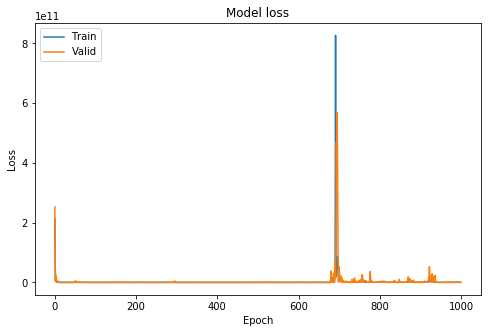

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


#get scores for loss

In [12]:

history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)

In [13]:
# evaluate model
loss = model.evaluate(XTrain, yTrain, verbose=2)
print( "mse: %f" %loss)

4/4 - 0s - loss: 1138733824.0000
mse: 1138733824.000000


In [14]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredVanilla = yPredListList 
#Test MAPE: 0.5149819512997876
#Test MdSA: 0.5037830307316448
#Test MSE: 34067736.27388393
#Test RMSE: 5836.757342384891

Test MAPE: 2.552834071836838
Test MdSA: 2.538045631842329
Test MSE: 477867136.73978794
Test RMSE: 21860.17238586622


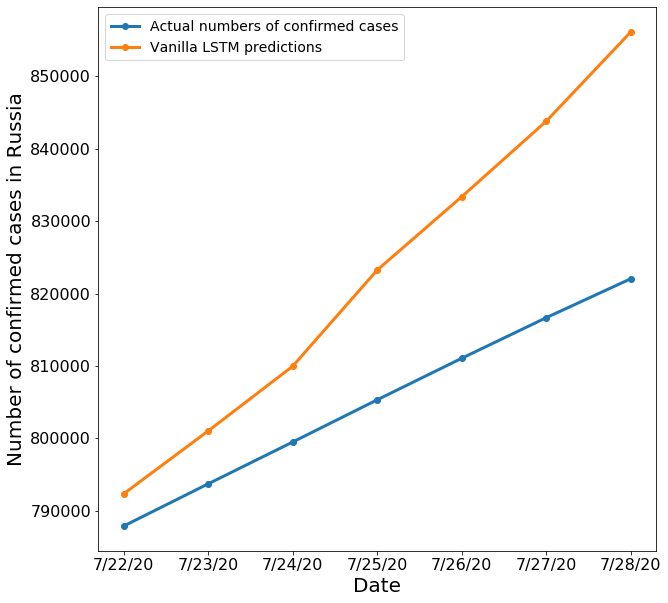

In [15]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]

plt.ylabel('Number of confirmed cases in Russia', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
#plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
#plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
#ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
#plt.savefig(os.path.join('Plots_3days_k7', 'predictions_{}.png'.format(countryName)), dpi=400)

In [16]:
yPredVanilla
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)

Test RMSE: 30674.46080040605


In [17]:
datesForPlottingList_df = pd.DataFrame(datesForPlottingList)
datesForPlottingList_df
groundTruthList_df = pd.DataFrame(groundTruthList)
groundTruthList_df
yPredVanilla[-1]#[786326.1, 791561.75, 795952.1, 810342.25, 813480.75, 813834.0, 838000.0]

[792336.0, 801026.1, 809968.25, 823253.25, 833386.8, 843821.2, 856149.06]

In [18]:
yPredVanilla[-1]
yPredVanilla_df = pd.DataFrame(yPredVanilla[-1])
yPredVanilla_df
#merge the three dataframes?
yPredVanilla_df

,0
0,792336.0000
1,801026.1250
2,809968.2500
3,823253.2500
4,833386.8125
5,843821.1875
6,856149.0625


In [19]:
dates = datesForPlottingList_df
actual = groundTruthList_df
predicted_vanilla = yPredVanilla_df
datesForPlottingList
groundTruthList #[787890, 793720, 799499, 805332, 811073, 816680, 822060]

[787890, 793720, 799499, 805332, 811073, 816680, 822060]

In [20]:
datesForPlottingList
groundTruthList
yPredVanilla
allvalues = {
    'Date': ['7/22/20', '7/23/20', '7/24/20', '7/25/20', '7/26/20', '7/27/20', '7/28/20'],
    'Actual':[787890, 793720, 799499, 805332, 811073, 816680, 822060],
    'Predicted_Vanilla': [86326.1, 791561.75, 795952.1, 810342.25, 813480.75, 813834.0, 838000.0]}

In [21]:
allvalues = pd.DataFrame (allvalues, columns = ['Date', 'Actual', 'Predicted_Vanilla'])
allvalues.to_csv('russia_3d_k7_vanilla.csv')
allvalues

,Date,Actual,Predicted_Vanilla
0,7/22/20,787890,86326.10
1,7/23/20,793720,791561.75
2,7/24/20,799499,795952.10
3,7/25/20,805332,810342.25
4,7/26/20,811073,813480.75
5,7/27/20,816680,813834.00
6,7/28/20,822060,838000.00


# Stacked LSTM

In [22]:
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
    model.add(LSTM(neurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
model.add(LSTM(neurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 1.7559397770309941
Updating best MAPE to 1.7559397770309941...
Updating best seed to 0...
1 1.4346095879403624
Updating best MAPE to 1.4346095879403624...
Updating best seed to 1...
2 4.6286556833688755
3 7.501696136638263
4 64.60812686792497
5 22.582281109167216
6 62.65545040844247
7 2.181563483004955
8 10.42194310140546
9 3.0820412906295687
10 0.760261620155161
Updating best MAPE to 0.760261620155161...
Updating best seed to 10...
11 0.253375878557524
Updating best MAPE to 0.253375878557524...
Updating best seed to 11...
12 6.805573931141194
13 0.8967520665125662
14 2.4856171534494638
15 3.0854362166147276
16 62.88124546694204
17 3.2814007143203097
18 1.9793549410050875
19 13.54829429305923
20 4.2293439447011565
21 2.292803382177361
22 6.038253245970902
23 5.486412661285677
24 61.44560508259392
25 5.024413387765997
26 3.2633445378230794
27 65.89890174549365
28 1.1537208440607698
29 64.29555843558202
30 65.45752453980987
31 10.463101229966698
32 63.12858837955498
33 2.96715806568690

In [23]:
model.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 3, 50)             10400     
_________________________________________________________________
lstm_302 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


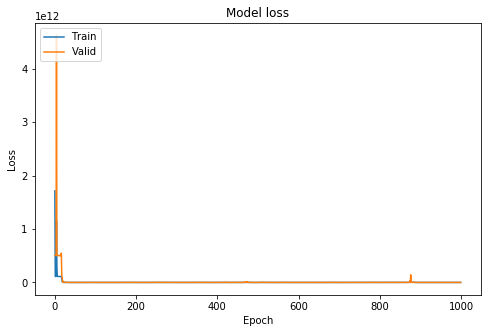

In [24]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [25]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredStacked = yPredListList
#Test MAPE: 0.9035797378799045
#Test MdSA: 0.889833226411918
#Test MSE: 66627325.00446428
#Test RMSE: 8162.556278793077

Test MAPE: 0.9035797378799045
Test MdSA: 0.889833226411918
Test MSE: 66627325.00446428
Test RMSE: 8162.556278793077


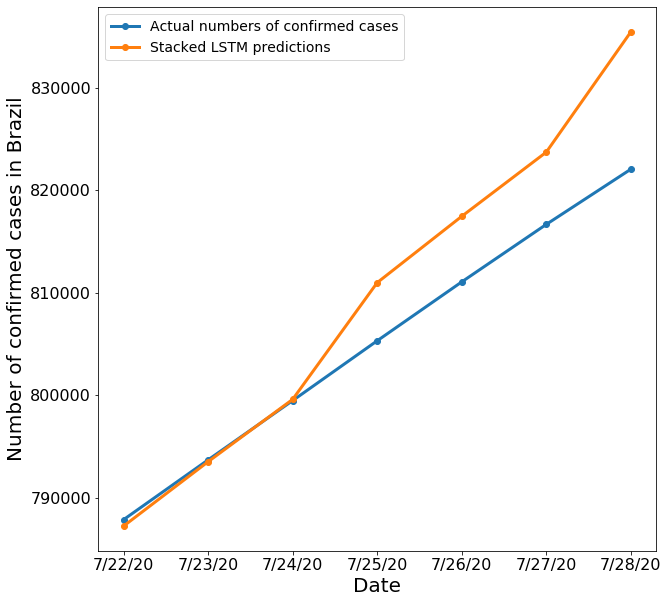

In [26]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
#plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
#plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
#ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
#plt.savefig(os.path.join('Plots_3days_k7', 'predictions_{}.png'.format(countryName)), dpi=400)

In [27]:

RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)

Test RMSE: 38589.30900324564


# Bi-directional LSTM

In [28]:
# define model
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 5.376859459219621
Updating best MAPE to 5.376859459219621...
Updating best seed to 0...
1 4.555612819712936
Updating best MAPE to 4.555612819712936...
Updating best seed to 1...
2 4.61383581334519
3 1.5271758823443222
Updating best MAPE to 1.5271758823443222...
Updating best seed to 3...
4 0.9683503571118347
Updating best MAPE to 0.9683503571118347...
Updating best seed to 4...
5 5.908275308348554
6 2.6699894983857297
7 5.141098286821991
8 3.8739553434683756
9 4.6915161360969275
10 99.94890800056409
11 2.823240621788785
12 5.800105292279462
13 99.95356795053904
14 2.052436875296092
15 2.5825005188745562
16 1.4129566395872726
17 3.5071434779661117
18 3.668918499150333
19 0.1795177092378309
Updating best MAPE to 0.1795177092378309...
Updating best seed to 19...
20 5.756009194234392
21 1.498539306400438
22 7.555935717843732
23 4.441827190799189
24 51.34408287986347
25 0.4028765607784865
26 3.3087409174183446
27 7.837485075944703
28 2.753938199498763
29 25.120181075888617
30 1.9614900842

In [29]:
model.summary()

Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_100 (Bidirecti (None, 100)               20800     
_________________________________________________________________
dense_302 (Dense)            (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


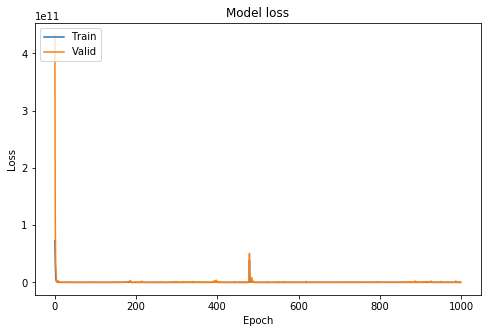

In [30]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [31]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredBidirectional = yPredListList
#Test MAPE: 0.675683122171473
#Test MdSA: 0.6633392779298023
#Test MSE: 40367388.83392857
#Test RMSE: 6353.533570693443

Test MAPE: 0.675683122171473
Test MdSA: 0.6633392779298023
Test MSE: 40367388.83392857
Test RMSE: 6353.533570693443


In [32]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 39879.528172271355


In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

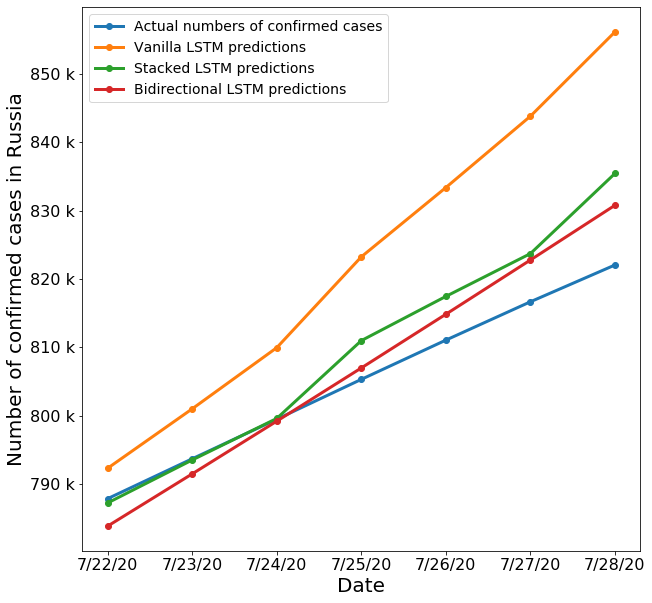

In [34]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Russia', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [35]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 20355.895056872498
#Test RMSE: 6571.488873710364
#Test RMSE: 4657.182319173027

Test RMSE: 20355.895056872498
Test RMSE: 6571.488873710364
Test RMSE: 4657.182319173027


In [36]:
groundTruthList
#[787890, 793720, 799499, 805332, 811073, 816680, 822060]

[787890, 793720, 799499, 805332, 811073, 816680, 822060]

In [37]:
yPredVanilla[-1]
#[792336.0, 801026.1, 809968.25, 823253.25, 833386.8, 843821.2, 856149.06]

[792336.0, 801026.1, 809968.25, 823253.25, 833386.8, 843821.2, 856149.06]

In [38]:
 yPredStacked[-1]
    #[787262.8, 793541.1, 799618.7, 811000.0, 817466.1, 823725.44, 835447.1]

[787262.8, 793541.1, 799618.7, 811000.0, 817466.1, 823725.44, 835447.1]

In [39]:
yPredBidirectional[-1]
[783873.25, 791511.2, 799220.0, 807002.3, 814858.44, 822788.94, 830794.75]

[783873.25, 791511.2, 799220.0, 807002.3, 814858.44, 822788.94, 830794.75]